<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Warnings" data-toc-modified-id="Warnings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>Warnings</strong></a></span></li><li><span><a href="#What-this-notebook-does" data-toc-modified-id="What-this-notebook-does-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>What this notebook does</a></span></li><li><span><a href="#Usual-Firedrake-preliminaries" data-toc-modified-id="Usual-Firedrake-preliminaries-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Usual Firedrake preliminaries</a></span></li><li><span><a href="#ODE-data-and-Discretization-Data" data-toc-modified-id="ODE-data-and-Discretization-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ODE data and Discretization Data</a></span></li><li><span><a href="#The-solver" data-toc-modified-id="The-solver-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The solver</a></span></li><li><span><a href="#Test-and-compare-errors" data-toc-modified-id="Test-and-compare-errors-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test and compare errors</a></span><ul class="toc-item"><li><span><a href="#Plot-solutions" data-toc-modified-id="Plot-solutions-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Plot solutions</a></span></li></ul></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exercises</a></span></li></ul></div>

# Example 2: Estimating errors in Firedrake


[Niall Madden](https://www.niallmadden.ie/) _Dec 2024_

This notebook outlines a simple approach to error estimation,  by comparing the computed solution with one obtained with a higher-order method (sometimes called a _hierarchical error estimator_).
It also presents the solver as a function, so that it is easy to call for different meshes, or different degree elements. It is part of Niall's [Introduction to Firedrake](https://niallmadden.ie/IntroToFiredrake)



## **Warnings**
1. If there is a bug in your code, and you are actually solving the wrong problem, this approach will not tell you that. However, if you are, it can help you determine the order of convergence, for example.
2. This approach can be expensive in higher dimensions.

## What this notebook does
We solve the ODE 
$$-\varepsilon u'' + r(x)u  = f(x) \text{ on } (0,1), \qquad\text{ with } u(0)=u(1)=0.$$
and then compare the solution with one obtained using a higher-order method.

You can choose $r$ and $f$ to be anything you like, within reason.

## Usual Firedrake preliminaries

In [1]:
import os
if "OMP_NUM_THREADS" not in os.environ:
    os.environ["OMP_NUM_THREADS"] = "1"  
%matplotlib inline

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

##  ODE data and Discretization Data

In [3]:
epsilon = 1.0e-1
# A choice of r and f
r = lambda x : 1+cos(pi*x)
f = lambda x : exp(-x)
## Use the following ones to compare with 01-Firedrake-GettingStarted.ipynb 
#r = lambda x : exp(-x)
#f = lambda x : sin(pi*x)*(epsilon*pi**2.0 + exp(-x)) 
N = 16

## The solver 

In [4]:
def RD1D_solver(epsilon, r, f, my_mesh, deg):
    Ue = FiniteElement("CG", my_mesh.ufl_cell(), deg)
    V = FunctionSpace(my_mesh, Ue)

    u = TrialFunction(V)
    v = TestFunction(V)
    x = SpatialCoordinate(my_mesh)
    a = epsilon*u.dx(0)*v.dx(0)*dx + r(x[0])*u*v*dx
    L = f(x[0])*v*dx   
    
    BCs = DirichletBC(V, 0.0, "on_boundary")
    
    uN = Function(V)
    solve(a == L, uN, bcs=BCs)
    return uN

## Test and compare errors


In [8]:
mesh1D = UnitIntervalMesh(N)
deg = 1 # The degree of the elements used
u1 = RD1D_solver(epsilon, r, f, mesh1D, deg)
u2 = RD1D_solver(epsilon, r, f, mesh1D, deg+1)  # benchmark

V = u1.function_space()  # get the function space from the solution

Diff = Function(V)
Diff.interpolate(u1-u2)
L2 = sqrt(assemble(Diff*Diff*dx))
H1  = sqrt(assemble(Diff.dx(0)*Diff.dx(0)*dx))
Energy = sqrt( float(epsilon)*H1**2.0 + L2**2.0)

Diff_vec = np.abs(Diff.dat.data_ro)
Max  = Diff_vec.max()

print(f"Errors: L2={L2 : 8.3e}, H1={H1 : 8.3e}, Energy={Energy : 8.3e}, Max={Max : 8.3e}")

Errors: L2= 4.425e-04, H1= 1.702e-03, Energy= 6.968e-04, Max= 5.882e-04


### Plot solutions

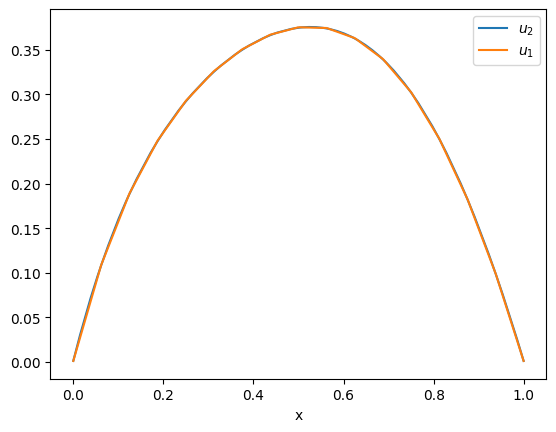

In [6]:
x_vals = mesh1D.coordinates.dat.data[:]

fig, axes = plt.subplots()
plot(u2, axes=axes, label='$u_2$') # true
plot(u1, axes=axes, label='$u_1$') # Use this for large N
#plt.plot(x_vals, u1.dat.data[:],'r--o', label='$u^N$')  # use for small N
plt.xlabel("x")
plt.legend()

## Exercises

1. Try using higher order elements. Note that accuracy improves, but the code runs more slowly.
1. Extend to solve convection-diffusion problem.
2. Instead of using a benchmark solution computed using the same mesh, but $p+1$ elements, try  computing it on a mesh with twice as many intervals, but the same degree elements.
